## Matching

In [2]:
import numpy as np
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import random

Graphviz is not installed. 
  Please install this program in order to visualize graphical models in pyAgrum. 
  See https://graphviz.org/download/


In [3]:
# !pip install pyAgrum

We are given this database coming from the historical records of a hospital

In [4]:
df = pd.read_csv("sample")
df

,smoker,treatment,dead
0,0,0,0
1,1,1,0
2,1,1,0
3,0,1,0
4,0,0,0
...,...,...,...
999995,0,0,0
999996,1,1,0
999997,0,0,0
999998,0,0,0


## How much will number of deaths change? 

How much will the number of deaths change if we decide to treat everybody from now on versus not treating anyone?

Our first instinct is to simply compute the percentages of deaths of the treated population versus the untreated population using the data we are given, and simply subtract one from the other.

In [5]:
treated = df[df["treatment"]==1]
untreated = df[df["treatment"]==0]

percentage_dead_treated = treated["dead"].mean()
percentage_dead_treated

0.32080451312239394

In [6]:
percentage_dead_untreated= untreated["dead"].mean()
percentage_dead_untreated

0.23595664229896648

In [7]:
percentage_dead_treated - percentage_dead_untreated

0.08484787082342746

Response: The percentage of deads will increase a 8.5% if we decide to treat everybody (it will jump from 23.56% to 32.08%). Consequently, we SHOULD NOT TREAT our population.

This result would then counsel us that we should not treat our population, but our common sense may be “tingling” and making us wonder if that is really the case. And rightly so, because we overlooked a tiny but very crucial detail, and that is that the treatment is not distributed equally between the smoking population and the non-smoking one. In other words, treatment is not randomized, and hence, this way of calculating the ATE is simply wrong.

BUT: The real effect of this treatment then, is a lowered percentage of deaths by an 8.3%, exactly the contrary that we got in the first calculations. Therefore, the real answer is that we should absolutely treat all patients. Now, to have this exact percentages is very rare. We can certainly approximate ATE with a good observational dataset, applying the same system, but the problem with this method arises when the dataset has a high dimensional set of covariates. Imagine a set of covariates in the hundreds. Computing this formula for all the covariates would be too cumbersome. It is not the case of this very simple example, but in the real world it is a very common circumstance. What should we do in those cases then?

## We can use matching on propensity score

Well, that is something that Rosenbaum and Rubin tried to solve in 1983 proposing that we use the propensity score (or probability of getting a treatment given a set of covariates) as a balancing score. Their reasoning goes as follows. A balancing score is any function of the set of covariates that captures all the information of the set that is dependent on treatment. Such a balancing score would allow us to model the relation between the confounders and treatment in a relatively simple way.|And the minimal expression of a balancing score is the propensity score.

Computing the propensity score is relatively simple, even in high dimensional sets of covariates. In these casps what we could do is model it using logistic regression with treatment as the target variable. But to be able to use this propensity score in the methods we will review next, there are some constraints.

To ensure this, formally, there are 2 assumptions that need to be met:
- The stable unit-treatment value assumption (SUTVA): Any outcome of any unit of the sample is independent of the treatment assignment to other units.
- Treatment assignment should be strongly ignorable given a set of covariates: It is if every unit of the sample has a chance (even if small) of receiving each treatment, and if the treatment assignment and outcome are conditionally independent given that set of covariates.

If these two assumptions are met, we are good to go with the methods we are going to review now.

### We start computing the propensities of each sample. 


As before, we will review the methods applying them to our specific example. As stated earlier, we were able to compute the exact ATE because we knew the accurate probabilities of every variable combination. These methods assume that we don't know them, because with high dimensional sets of covariates that would be nearly impossible. Therefore, we will compare their estimations of the value of ATE to the known true result.


Let's start by computing our propensity score values. It is defined formally as follows:

\begin{align}
e(x)=p(z=1|x)
\end{align}

**In our case:**

Where $x$ is a specific combination of the set of covariates and $z=1$ equates to receiving treatment.
And in our specific case it is translated to:

\begin{align}
e(smoker)=p(treatment=1|smoker)
\end{align}


### We start by computing the propensity of each patient

In [8]:
n_smokers = len(df[df["smoker"]==1])
n_treated_smokers = len(df[(df["smoker"]==1) & (df["treatment"]==1)])
e_smoker = n_treated_smokers/n_smokers
print(e_smoker)

0.551550247155304


In [9]:
n_non_smokers = len(df[df["smoker"]==0])
n_treated_non_smokers = len(df[(df["smoker"]==0) & (df["treatment"]==1)])
e_non_smoker = n_treated_non_smokers/n_non_smokers
print(e_non_smoker)

0.20002946321174753


In [10]:
df["propensity"] = df["smoker"]*e_smoker + (1-df["smoker"])*e_non_smoker
df

,smoker,treatment,dead,propensity
0,0,0,0,0.200029
1,1,1,0,0.551550
2,1,1,0,0.551550
3,0,1,0,0.200029
4,0,0,0,0.200029
...,...,...,...,...
999995,0,0,0,0.200029
999996,1,1,0,0.551550
999997,0,0,0,0.200029
999998,0,0,0,0.200029


In this case there are only 2 possible values, since our confounder is binary. Once computed and added to our dataframe we can pair match in two different ways.


### We match each treated patient with a control patient that has the same propensity score. However, we reduce the number of treated patients for efficiency reasons.

In this version of pair matching, we couple each treated patient with a control patient that has the same propensity score. For this example, we reduce the number of treated patients for efficiency reasons.

In [11]:
treated = df[df["treatment"]==1].sample(100)
treated = treated.reset_index(drop=True)
treated

,smoker,treatment,dead,propensity
0,0,1,0,0.200029
1,1,1,1,0.551550
2,0,1,0,0.200029
3,1,1,1,0.551550
4,0,1,0,0.200029
...,...,...,...,...
95,1,1,0,0.551550
96,0,1,0,0.200029
97,0,1,0,0.200029
98,1,1,1,0.551550


### We match each treated patient with a randomly sampled untreated patient with the same propensity score

Now, every treated patient gets a randomly sampled untreated patient with the same propensity score:

In [12]:
untreated = df[df["treatment"]==0]
matched_control = []
def add_matched_control(patient):
    control_patient = untreated[untreated["propensity"]==patient["propensity"]].sample().iloc[0]
    matched_control.append(control_patient)
    
treated.apply(add_matched_control, axis=1)
matched_control_df = pd.DataFrame(matched_control).reset_index(drop=True)
matched_control_df

,smoker,treatment,dead,propensity
0,0.0,0.0,0.0,0.200029
1,1.0,0.0,1.0,0.551550
2,0.0,0.0,1.0,0.200029
3,1.0,0.0,1.0,0.551550
4,0.0,0.0,0.0,0.200029
...,...,...,...,...
95,1.0,0.0,0.0,0.551550
96,0.0,0.0,1.0,0.200029
97,0.0,0.0,0.0,0.200029
98,1.0,0.0,1.0,0.551550


Now, every treated patient gets a randomly sampled untreated patient with the same propensity score:

In [13]:
paired_sample = treated.join(matched_control_df, rsuffix="_control")
paired_sample


,smoker,treatment,dead,propensity,smoker_control,treatment_control,dead_control,propensity_control
0,0,1,0,0.200029,0.0,0.0,0.0,0.200029
1,1,1,1,0.551550,1.0,0.0,1.0,0.551550
2,0,1,0,0.200029,0.0,0.0,1.0,0.200029
3,1,1,1,0.551550,1.0,0.0,1.0,0.551550
4,0,1,0,0.200029,0.0,0.0,0.0,0.200029
...,...,...,...,...,...,...,...,...
95,1,1,0,0.551550,1.0,0.0,0.0,0.551550
96,0,1,0,0.200029,0.0,0.0,1.0,0.200029
97,0,1,0,0.200029,0.0,0.0,0.0,0.200029
98,1,1,1,0.551550,1.0,0.0,1.0,0.551550


In [14]:
ATE = (paired_sample["dead"]-paired_sample["dead_control"]).mean()
ATE

-0.14

We get as a result that the percentage of deaths is effectively estimated to decrease, which is good as it is in line with the real effect computed before. However, we know that the real ATE is 0.083. This result is clearly biased.



**Response: The percentage of deads is estimated to decrease!!!**

Consequently, we should treat our population.

**However, we know that the real ATE is 0.083. Why is this calculation so inacurate? ...**

### Let's take an alternative path to use propensity score matching
We start by taking a look at the distribution of propensity scores

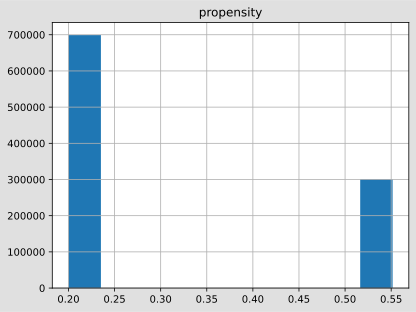

In [15]:
df.hist("propensity");

Clearly, we have a majority of the patients getting a low propensity score.

We can split patients into two groups, those with high propensity (> 0.5) and those with low propensity (<=0.5):

### We can split patients into two groups, those with high propensity (> 0.5) and those with low propensity (<=0.5)

In [16]:
high_propensity = df[df["propensity"]>0.5]
low_propensity = df[df["propensity"]<=0.5]
counts = np.array([len(low_propensity), len(high_propensity)])
percentages= counts / np.sum(counts)
percentages

array([0.699177, 0.300823])

### Build a paired sample 

And now we build a paired sample, but unlike before both treated and untreated populations are sampled from high or low propensity score population at random.

In [17]:
n_samples=1000
samples = []
for i in range(n_samples):
    is_high_propensity = random.random()>percentages[0]
    if is_high_propensity:
        treated_patient = high_propensity[high_propensity["treatment"]==1].sample().iloc[0]
        untreated_patient = high_propensity[high_propensity["treatment"]==0].sample().iloc[0]
    else:
        treated_patient = low_propensity[low_propensity["treatment"]==1].sample().iloc[0]
        untreated_patient = low_propensity[low_propensity["treatment"]==0].sample().iloc[0]
    samples.append((treated_patient, untreated_patient))

In [18]:
individual_treatment_effect = np.zeros(n_samples)
i = 0
for t, c in samples:
    individual_treatment_effect[i] = t["dead"]-c["dead"]
    i+=1


In [19]:
ATE=individual_treatment_effect.mean()
ATE

-0.063

After calculating the value of ATE for this new paired dataset, we can see that the value is much less biased than with the first version of the pair matching.

### We have managed to reduce the bias by sampling first from the distribution of propensity scores. 

Can we do better?

### Subclassification on propensity score

Here the approach is related to the second version of pair matching, as it relies on the distribution of the propensity score. The hist of it is that we can subdivide our population by the categories of a factorized by ranges propensity score. With our population classified in each category (in this case only two, as the covariate is binary), we only need to compute the ATE for each subclass, and then apply the next formula:
$$
A T E=\text { Percentage }_{1} * \text { ATE }_{1}+\ldots+\text { Percentage }_{n} * A T E_{n}
$$

In [20]:
n_smokers = len(df[df["smoker"]==1])
n_treated_smokers = len(df[(df["smoker"]==1) & (df["treatment"]==1)])
e_smoker = n_treated_smokers/n_smokers
print(e_smoker)

0.551550247155304


In [21]:
n_non_smokers = len(df[df["smoker"]==0])
n_treated_non_smokers = len(df[(df["smoker"]==0) & (df["treatment"]==1)])
e_non_smoker = n_treated_non_smokers/n_non_smokers
print(e_non_smoker)

0.20002946321174753


### Compute the propensity score for each patient. 

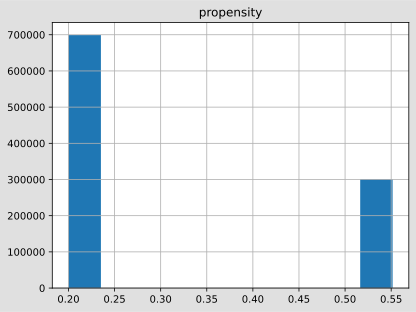

In [22]:
df["propensity"]=df["smoker"]*e_smoker + (1-df["smoker"])*e_non_smoker
df.hist("propensity")
pass

In [23]:
high_propensity = df[df["propensity"]==e_smoker]
low_propensity = df[df["propensity"]==e_non_smoker]
counts = np.array([len(low_propensity),len(high_propensity)])
percentages= counts / np.sum(counts)
percentages

array([0.699177, 0.300823])

In [24]:
##################################################

high_propensity_treated = high_propensity[high_propensity["treatment"]==1]
high_propensity_untreated = high_propensity[high_propensity["treatment"]==0]
ATE_high_propensity = high_propensity_treated["dead"].mean()-high_propensity_untreated["dead"].mean()
ATE_high_propensity

-0.30154970389303043

In [25]:
low_propensity_treated = low_propensity[low_propensity["treatment"]==1]
low_propensity_untreated = low_propensity[low_propensity["treatment"]==0]
ATE_low_propensity = low_propensity_treated["dead"].mean()-low_propensity_untreated["dead"].mean()
ATE_low_propensity

0.010967865389731754

In [26]:
ATE = percentages[0] * ATE_low_propensity + percentages[1] * ATE_high_propensity

In [27]:
ATE

-0.0830446073546166

After doing so our results is very very close to the known true value of ATE.


**Response: The percentage of deads is estimated to decrease!!!**

Consequently, we should treat our population.

**USEFUL LINKS**

https://towardsdatascience.com/a-hands-on-introduction-to-propensity-score-use-for-beginners-856302b632ac

https://github.com/cerquide/propensity_score_talk

======

https://analyticsmayhem.com/digital-analytics/propensity-score-matching-python/

https://github.com/konosp/propensity-score-matching/blob/main/propensity_score_matching_v2.ipynb

https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html